# **Dataset & Description**



[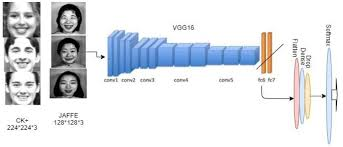](http://)


The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.








[Dataset link ](https://www.kaggle.com/msambare/fer2013)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import os,cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tf_explain.core.grad_cam import GradCAM

from skimage import io
import os, random

from keras.preprocessing import image
import keras.utils as image

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [30]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [31]:
train_dataset  = train_datagen.flow_from_directory(directory = './FER2013 - Images/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [32]:
valid_dataset = valid_datagen.flow_from_directory(directory = './FER2013 - Images/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [33]:
test_dataset = test_datagen.flow_from_directory(directory = './FER2013 - Images/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [7]:
step_size_test = test_dataset.n//test_dataset.batch_size
step_size_test

112

(48, 48, 3)
(1, 48, 48, 3)


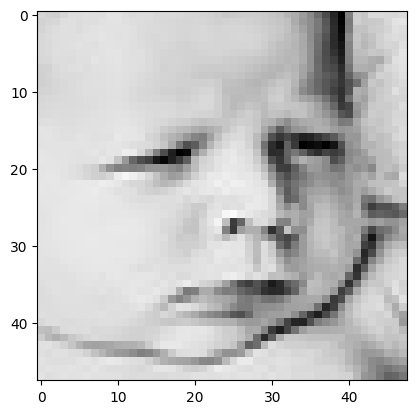

In [8]:
from keras.preprocessing import image
img = tf.keras.utils.load_img("./FER2013 - Images/test/angry/PrivateTest_88305.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [34]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [35]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [36]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [37]:
# Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

In [13]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [16]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [18]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 100,verbose = 1)

Epoch 1/100
359/359 [==============================] - 140s 388ms/step - loss: 1.9279 - accuracy: 0.8546 - precision: 0.1633 - recall: 0.0043 - auc: 0.5981 - f1_score: 0.0082 - val_loss: 1.8448 - val_accuracy: 0.8564 - val_precision: 0.2308 - val_recall: 0.0021 - val_auc: 0.6265 - val_f1_score: 0.0041
Epoch 2/100
359/359 [==============================] - 26s 71ms/step - loss: 1.8348 - accuracy: 0.8569 - precision: 0.2405 - recall: 8.2724e-04 - auc: 0.6359 - f1_score: 0.0016 - val_loss: 1.8241 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6404 - val_f1_score: 0.0000e+00
Epoch 3/100
359/359 [==============================] - 22s 62ms/step - loss: 1.8219 - accuracy: 0.8570 - precision: 0.1562 - recall: 2.1769e-04 - auc: 0.6406 - f1_score: 4.2854e-04 - val_loss: 1.8054 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6522 - val_f1_score: 0.0000e+00
Epoch 4/100
359/359 [==============================] - 20s 

### Quantitative Evaluation

In [ ]:
#EVALUATION

print('Train Accuracy: ', round(history.history['accuracy'][-1],2))
print('Train Loss: ', round(history.history['loss'][-1],2))
print('Train Precision: ', round(history.history['precision'][-1],2))
print('Train Recall: ', round(history.history['recall'][-1],2))
print('Train F1-Score: ', round(history.history['f1_score'][-1],2))

In [ ]:
#EVALUATION

print('Test Accuracy: ', round(history.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history.history['val_loss'][-1],2))
print('Test Precision: ', round(history.history['val_precision'][-1],2))
print('Test Recall: ', round(history.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history.history['val_f1_score'][-1],2))

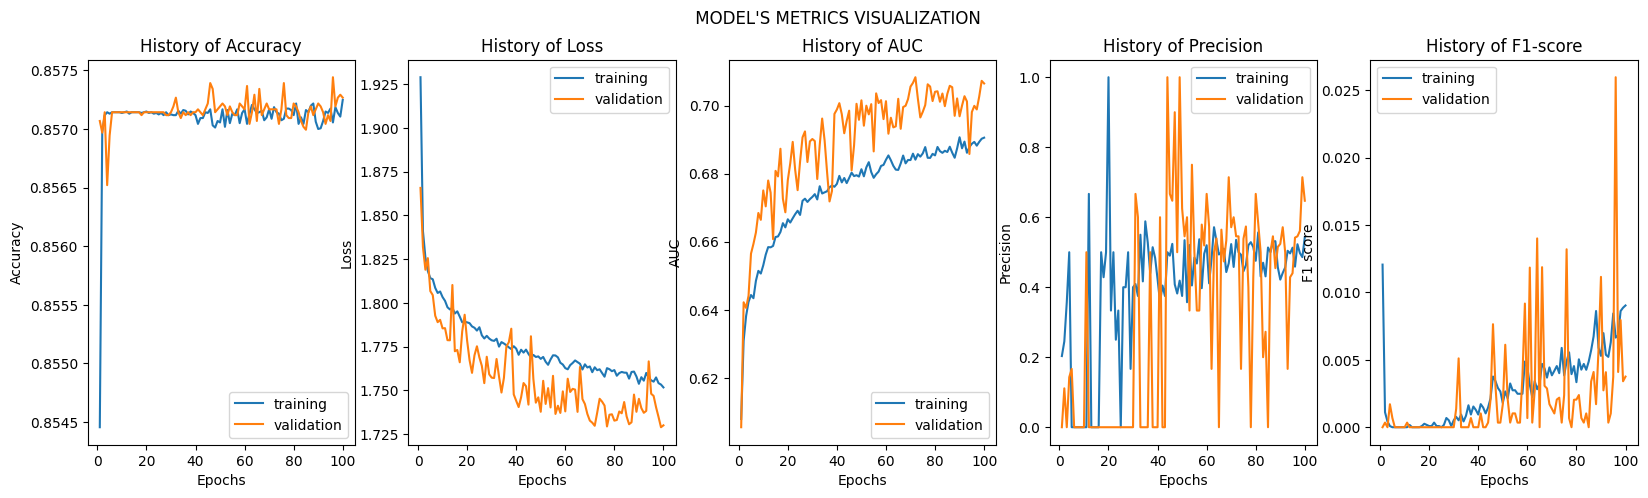

In [16]:
#%% PLOTTING RESULTS (Train vs Validation)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc):
    
    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
             
              )

### Hyperparameter tuning

In [38]:
# Tuned parameters
epochs = 150
callbacks = [ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10),ModelCheckpoint('resnetFER2013.h5')]
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('resnetCK+.h5')
es = EarlyStopping(verbose=1, patience=20)

In [40]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [41]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = epochs,verbose = 1,callbacks=callbacks)

Epoch 1/150
359/359 [==============================] - 27s 67ms/step - loss: 1.9031 - accuracy: 0.8561 - precision: 0.2682 - recall: 0.0044 - auc: 0.6352 - f1_score: 0.0066 - val_loss: 1.8371 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6316 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/150
359/359 [==============================] - 19s 54ms/step - loss: 1.8348 - accuracy: 0.8570 - precision: 0.2653 - recall: 5.6600e-04 - auc: 0.6347 - f1_score: 0.0011 - val_loss: 1.8174 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6477 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/150
359/359 [==============================] - 20s 55ms/step - loss: 1.8221 - accuracy: 0.8571 - precision: 0.5000 - recall: 1.3062e-04 - auc: 0.6405 - f1_score: 2.5712e-04 - val_loss: 1.8200 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6515 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/15

### Quantitative Evaluation

In [50]:
#EVALUATION

print('Train Accuracy: ', round(history.history['accuracy'][-1],2))
print('Train Loss: ', round(history.history['loss'][-1],2))
print('Train Precision: ', round(history.history['precision'][-1],2))
print('Train Recall: ', round(history.history['recall'][-1],2))
print('Train F1-Score: ', round(history.history['f1_score'][-1],2))

Train Accuracy:  0.86
Train Loss:  1.74
Train Precision:  0.55
Train Recall:  0.01
Train F1-Score:  0.02


In [52]:
#EVALUATION

print('Test Accuracy: ', round(history.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history.history['val_loss'][-1],2))
print('Test Precision: ', round(history.history['val_precision'][-1],2))
print('Test Recall: ', round(history.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history.history['val_f1_score'][-1],2))

Test Accuracy:  0.86
Test Loss:  1.71
Test Precision:  0.64
Test Recall:  0.01
Test F1-Score:  0.02


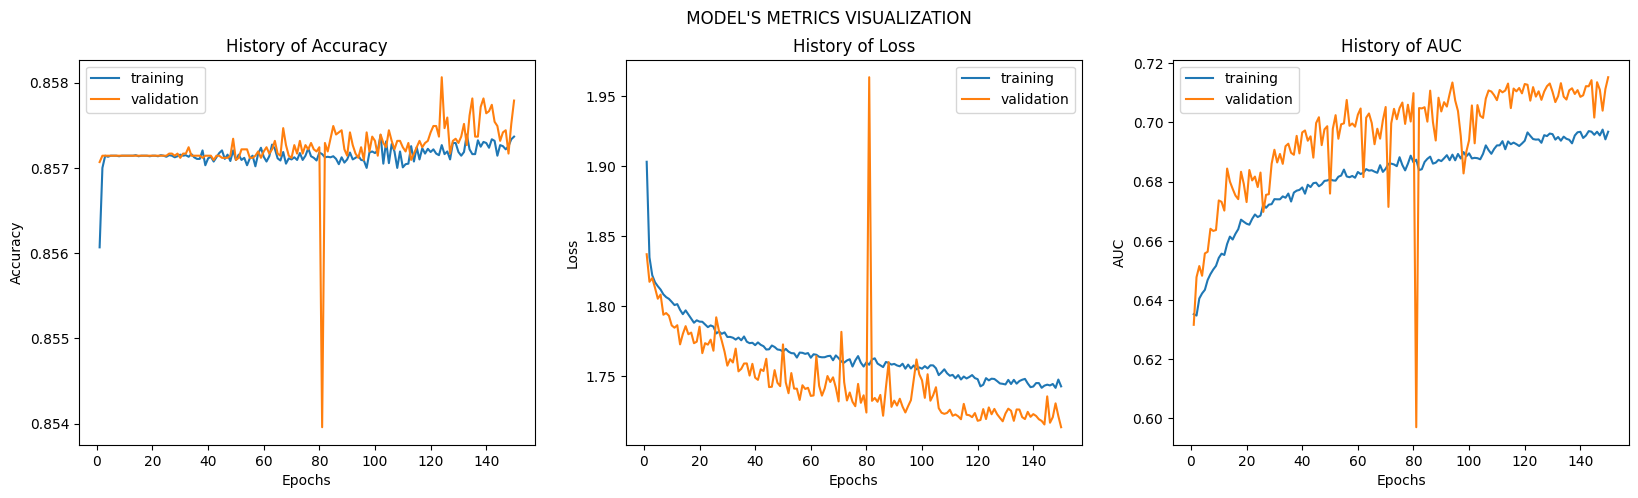

In [47]:
#%% PLOTTING RESULTS (Train vs Validation)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc):
    
    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
             
              )

### Qualitative Evaluation

1/1 [==============================] - 4s 4s/step


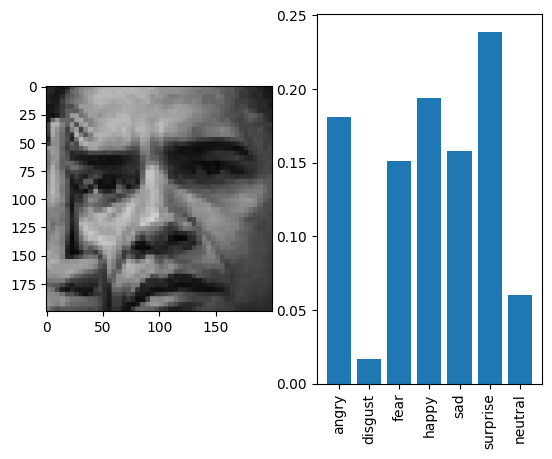

Expression Prediction: surprise
1/1 [==============================] - 0s 122ms/step


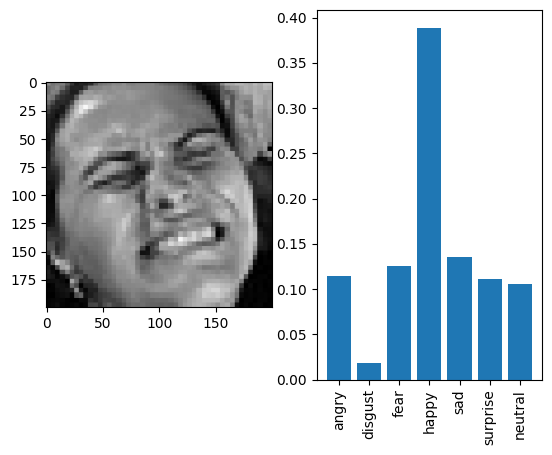

Expression Prediction: happy
1/1 [==============================] - 0s 63ms/step


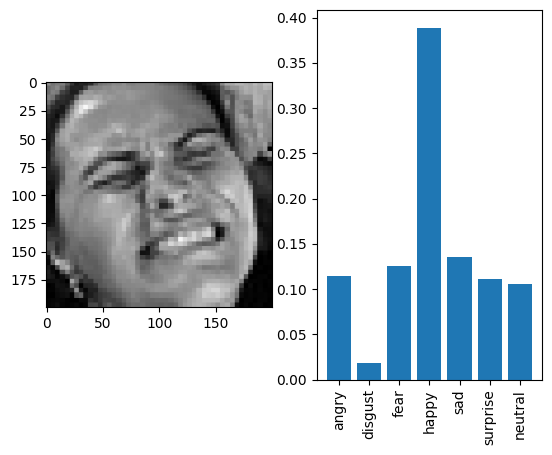

Expression Prediction: happy
1/1 [==============================] - 0s 212ms/step


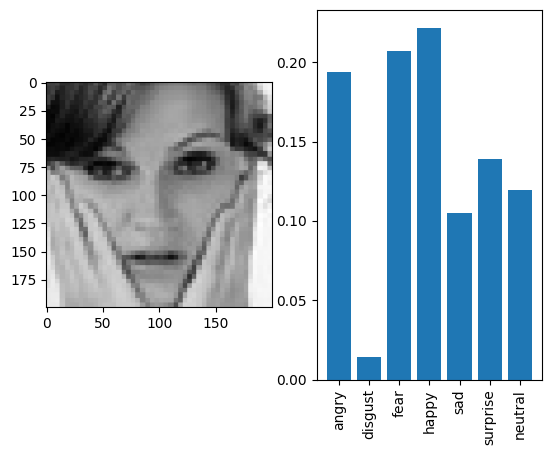

Expression Prediction: happy
1/1 [==============================] - 0s 75ms/step


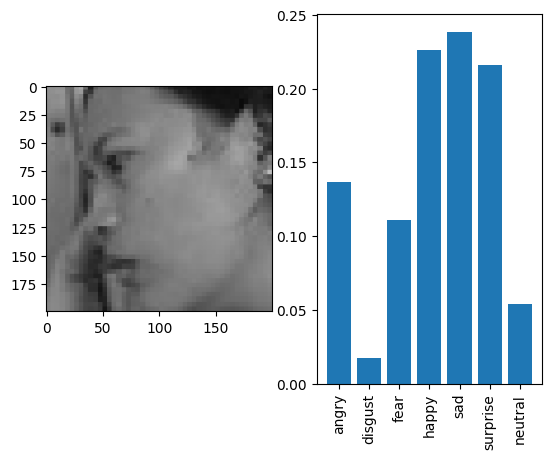

Expression Prediction: sad
1/1 [==============================] - 0s 34ms/step


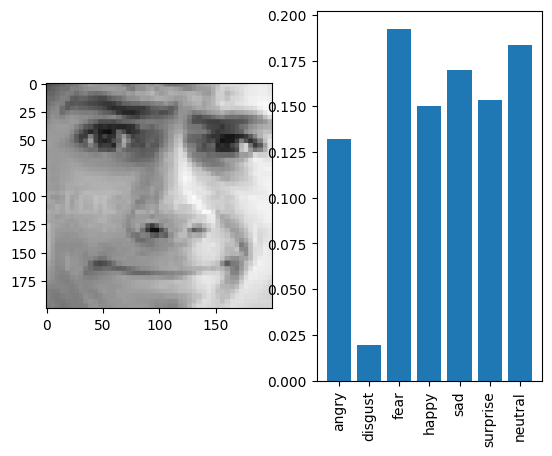

Expression Prediction: fear
1/1 [==============================] - 0s 85ms/step


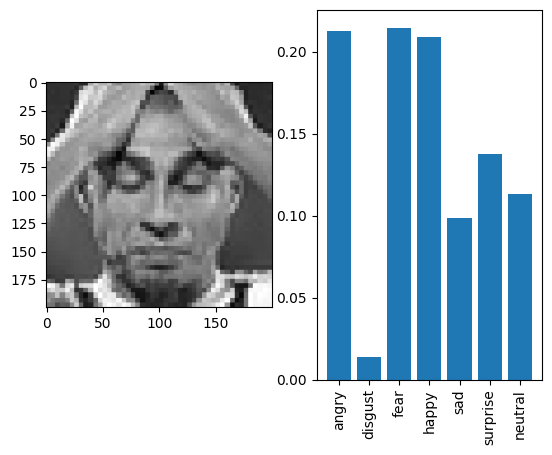

Expression Prediction: fear
1/1 [==============================] - 0s 114ms/step


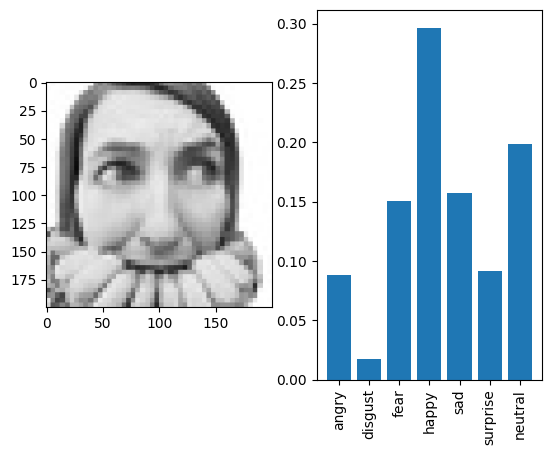

Expression Prediction: happy
1/1 [==============================] - 0s 20ms/step


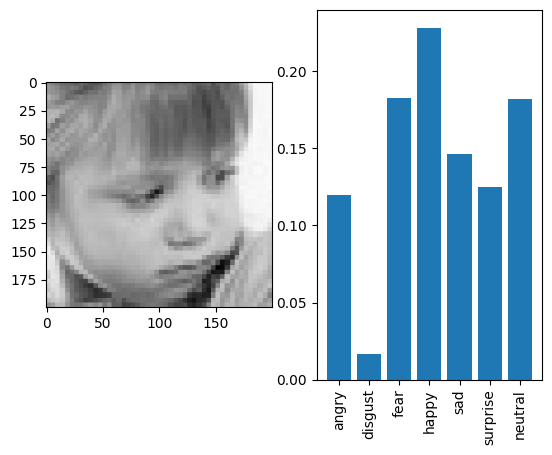

Expression Prediction: happy
1/1 [==============================] - 0s 104ms/step


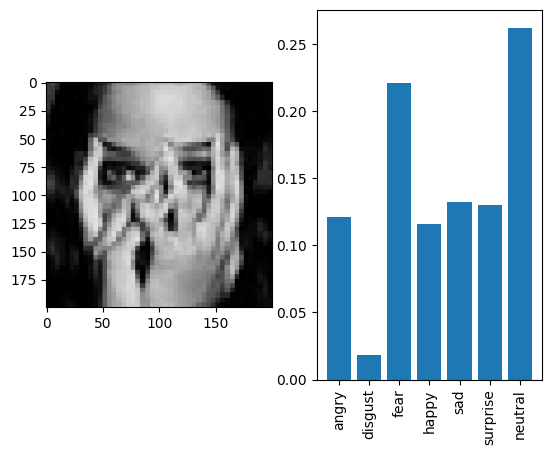

Expression Prediction: neutral


In [62]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
for i in range(0, 10):
    randimg = random.choice(os.listdir("./FER2013 - Images/test/fear"))
    randimgpath = "./FER2013 - Images/test/fear/" + randimg
    img = image.load_img(randimgpath, target_size = (48, 48))
    show_img = image.load_img(randimgpath, target_size = (200, 200))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255

    custom = model.predict(x)

    x = np.array(x, 'float32')
    x = x.reshape([48, 48, 3]);

    plt.gray()
    plt.subplot(1,2,1)
    plt.imshow(show_img)
    
    plt.subplot(1,2,2)
    plt.bar(objects,custom[0])
    plt.xticks(rotation=90)
    
    plt.show()

    a = custom[0]
    m = a[0]
    for i in range(0,len(a)):
        if a[i] >= m:
            m = a[i]
            ind = i

    print('Expression Prediction:',objects[ind])

90/90 [==============================] - 28s 213ms/step
Confusion matrix, without normalization
[[ 30   0 117 317  18 194 123]
 [  3   0   7  33   3  30  11]
 [ 27   0 117 318  33 210 114]
 [ 55   0 215 561  30 380 202]
 [ 27   0 132 400  35 263 136]
 [ 34   0 118 376  31 258 149]
 [ 27   0  72 254  19 171  91]]


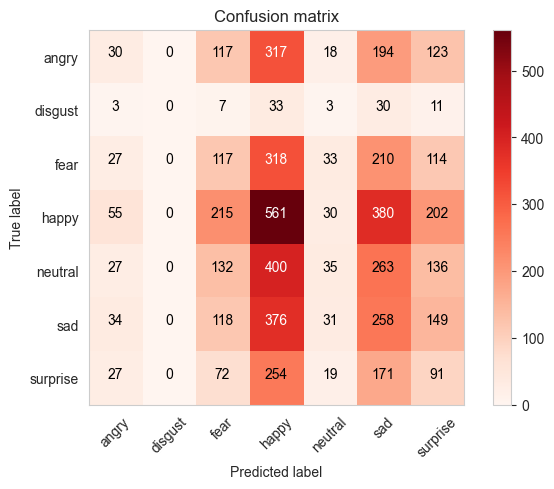

In [76]:
import seaborn as sns
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap='viridis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_true = valid_dataset.classes
y_hat =  model.predict(valid_dataset)
y_hat = tf.argmax(y_hat, axis = 1).numpy()
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_true, y_pred = y_hat)
plot_confusion_matrix(cm, classes, cmap = 'Reds')
plt.savefig('confmat.png')